<hr style="height:3pt">

# Visualization of BNN on Synthetic Regression

This notebook brings together the subpace construction and inference to show epistemic/aleatoric uncertainty on a synthetic regression problem

<hr style="height:3pt">

In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from visualization import plot_predictive
from elliptical_slice import elliptical_slice
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
sns.set()

In [2]:
# Load in data to train MLP
data = np.load('../data/data.npy')
x, y = data[:, 0], data[:, 1]

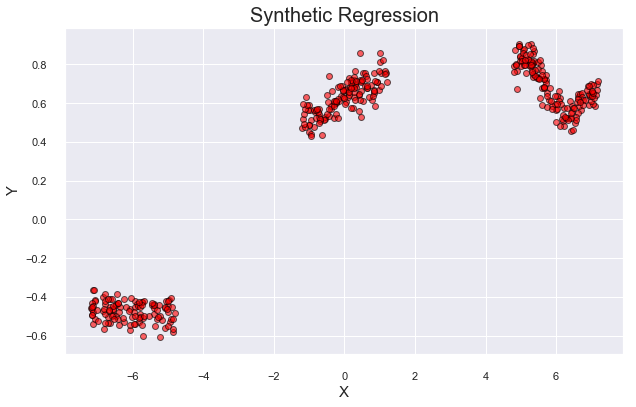

In [3]:
# Visualize data
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, facecolor='red', edgecolor='black', alpha=.6)
ax.set_title('Synthetic Regression', fontsize=20)
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15);

Each of the subspace construction methods operate on a network with pre-trained weights. For the synthetic regression dataset, the authors use a fully connected network with 4 hidden layers that have [200, 50, 50, 50] neurons respectively. The network takes two input features: $x$ and $x^2$, and outputs a single real value $y$. We first recreate this network using pytorch as a backend.

In [4]:
# Define MLP in pytorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 200)    # hidden layer 1
        self.fc2 = nn.Linear(200, 50)   # hidden layer 2
        self.fc3 = nn.Linear(50, 50)    # hidden layer 3
        self.fc4 = nn.Linear(50, 50)    # hidden layer 4
        self.output = nn.Linear(50, 1)  # output layer
        
    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x).relu()
        x = self.fc4(x).relu()

        return self.output(x)

The authors define their loss function to be "Minus Gaussian Likelihood" which is just MSE / $2\sigma^2$. They set $\sigma^2 = 1$, therefore we felt it was sufficient to just use MSE as the loss, as it's equal to just a factor of $1/2$.

In [5]:
# Prepare data
def features(x):
    return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])

y = y.reshape(-1, 1)
f = features(x)
dataset = torch.utils.data.TensorDataset(torch.from_numpy(f.astype(np.float32)), 
                                         torch.from_numpy(y.astype(np.float32)))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

# Define loss to be MSE
criterion = nn.MSELoss()

In [6]:
def decay_lr(optimizer, epoch_ratio, lr_init=1e-2, lr_ratio=.05, start=0.5):
    '''
    Decay the learning rate linearly from 'start' until 'min_lr'
    '''
    if epoch_ratio <= start:
        factor = 1.0
    else:
        factor = np.max([lr_ratio, 1.0 - (1.0 - lr_ratio) * (epoch_ratio - 0.5) / 0.4])
        
    lr = factor * lr_init
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    return lr

In [7]:
# Run the training loop on the data
def train_model(model, dataloader, optimizer, criterion, epochs=3000, print_freq=1000):
    model.train() # prep model layers for training
    
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        
        # Implementation of learning rate decay from paper
        epoch_ratio = (epoch + 1) / epochs
        lr = decay_lr(optimizer, epoch_ratio)
        
        for inputs, labels in dataloader:
            optimizer.zero_grad()  # clear gradients
            
            preds = model(inputs)  # perform a forward pass
            loss = criterion(preds, labels)  # compute the loss

            loss.backward()   # backpropagate
            optimizer.step()  # update the weights

            epoch_loss += loss.data.item()*inputs.shape[0]
            
        # Print output
        if (epoch % print_freq == 0 or epoch == epochs - 1):
            print('Epoch %d | LR: %g | Loss: %.4f' % (epoch, lr, epoch_loss))

In [9]:
# Train 5 separate models
for i in range(5):
    print('Training model {}...'.format(i+1))
    model = MLP()
    # Define optimizer as SGD w/ high momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=.95)
    train_model(model, dataloader, optimizer, criterion)
#     torch.save(model.state_dict(), "checkpoints/sgd_checkpoint{}.pt".format(i+1))

Training model 1...


Epoch 0 | LR: 0.01 | Loss: 136.3990
Epoch 1000 | LR: 0.01 | Loss: 1.1057
Epoch 2000 | LR: 0.00603375 | Loss: 0.9879
Epoch 2999 | LR: 0.0005 | Loss: 0.9645

Training model 2...


Epoch 0 | LR: 0.01 | Loss: 93.1858
Epoch 1000 | LR: 0.01 | Loss: 1.0494
Epoch 2000 | LR: 0.00603375 | Loss: 0.9898
Epoch 2999 | LR: 0.0005 | Loss: 0.9747

Training model 3...


Epoch 0 | LR: 0.01 | Loss: 119.7771
Epoch 1000 | LR: 0.01 | Loss: 1.0370
Epoch 2000 | LR: 0.00603375 | Loss: 1.0070
Epoch 2999 | LR: 0.0005 | Loss: 0.9840

Training model 4...


Epoch 0 | LR: 0.01 | Loss: 107.6616
Epoch 1000 | LR: 0.01 | Loss: 1.1168
Epoch 2000 | LR: 0.00603375 | Loss: 1.0034
Epoch 2999 | LR: 0.0005 | Loss: 0.9804

Training model 5...


Epoch 0 | LR: 0.01 | Loss: 111.3413
Epoch 1000 | LR: 0.01 | Loss: 1.0515
Epoch 2000 | LR: 0.00603375 | Loss: 1.0107
Epoch 2999 | LR: 0.0005 | Loss: 0.9798



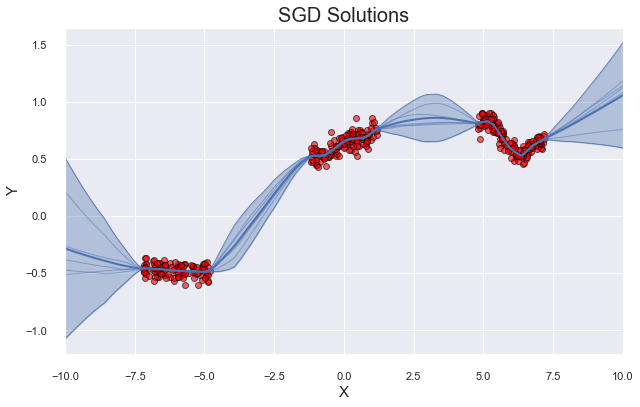

In [10]:
# Load in models and visualize
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(5):
    model.load_state_dict(torch.load("checkpoints/sgd_checkpoint" + str(i+1) + ".pt"))
    out = model(inp).detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="SGD Solutions")

## SWAG & Random Subspace

In order to get the parameters with which to initialize our subspaces, we need to write a method that performs Stochastic Weight Averaging (SWAG). SWAG is a method for approximating the posterior of a BNN using the SGD iterates (https://arxiv.org/pdf/1902.02476.pdf). More specifically the algorithm works by computing the first two moments (mean, covariance) for a Gaussian from the SGD iterates.

In [11]:
def SWAG(model, dataloader, optimizer, criterion, epochs=3000, 
         print_freq=1000, swag_start=2000, M=1e5, verbose=False):
    '''Implementation of Stochastic Weight Averaging'''
    model.train() # prep model layers for training
    
    # initialize first moment as vectors w/ length = num model parameters
    num_params = sum(param.numel() for param in model.parameters())
    first_moment = torch.zeros(num_params)
    
    # initialize deviation matrix 'A'
    A = torch.empty(0, num_params, dtype=torch.float32)  
    
    n_iterates = 0
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        
        # Implementation of learning rate decay from paper
        epoch_ratio = (epoch + 1) / swag_start
        lr = decay_lr(optimizer, epoch_ratio, lr_ratio=1)
        
        for inputs, labels in dataloader:
            optimizer.zero_grad()  # clear gradients
            
            preds = model(inputs)  # perform a forward pass
            loss = criterion(preds, labels)  # compute the loss

            loss.backward()  # backpropagate
            optimizer.step()  # update the weights

            epoch_loss += loss.data.item()*inputs.shape[0]
            
        # Print output
        if (epoch % print_freq == 0 or epoch == epochs - 1) and verbose:
            print('Epoch %d | LR: %g | Loss: %.4f' % (epoch, lr, epoch_loss))
            
        # Average gradient weights
        if epoch > swag_start:
            # obtain a flattened vector of weights
            weights_list = [param.detach() for param in model.parameters()]
            w = torch.cat([w.contiguous().view(-1,1) for w in weights_list]).view(-1)
            
            # update the first moment
            first_moment = (n_iterates*first_moment + w)/(n_iterates + 1)
            
            # update 'a' matrix  (following their code implementation)
            a = w - first_moment 
            A = torch.cat((A, a.view(1, -1)), dim=0)
            
            # only store the last 'M' deviation vectors if memory limited
            if A.shape[1] > M:  
                A = A[1:, :]
                
            n_iterates += 1
            
    return first_moment.double(), A.numpy()

In [12]:
# Generate a random subspace
class RandomSubspace():
    def __init__(self, model_info, rank=10, seed=1, preloaded=None):
        self.model_info = model_info
        self.rank = rank
        
        if preloaded is not None:
            print('Loading pretrained random weights...')
            self.shift = preloaded['swag_shift']
            
        else:
            print('Computing Random Subspace...')
        
            self.shift, _ = SWAG(model_info['model'], model_info['dataloader'], 
                             model_info['optimizer'], model_info['criterion'])
            
        self.num_parameters = self.shift.shape[0]
        torch.manual_seed(seed)
        self.P = torch.randn(rank, self.num_parameters)  # self.cov_factor in author's github
        self.P /= torch.norm(self.P, dim=1)[:, None]

In [15]:
def preload(path="../data/swag_checkpoint0-3000.pt"):
    # Load in data from authors
    swag_model = torch.load(path)['state_dict']
    swag_shift = swag_model['mean']
    swag_A = swag_model['subspace.cov_mat_sqrt']

    model_weights = np.array([])
    for key, value in swag_model.items():
        if 'base_model' in key:
            model_weights = np.append(model_weights, value.numpy().flatten())

    preloaded = {'swag_shift': swag_shift, 'swag_A': swag_A, 'model_weights': model_weights}
    
    return preloaded

In [16]:
preloaded = preload()
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=.95)
model_info = {'model': model, 'dataloader': dataloader, 'optimizer': optimizer, 'criterion': criterion}
rs = RandomSubspace(model_info, preloaded=preloaded)

Loading pretrained random weights...


## Inference w/ ESS & Random Subspace

Link to the ESS paper: http://proceedings.mlr.press/v9/murray10a/murray10a.pdf 

In [17]:
# Utility functions
def unflatten_like(vector, likeTensorList):
    # Takes a flat torch.tensor and unflattens it to a list of torch.tensors (model params)
    # shaped like likeTensorList
    outList = []
    i=0
    for tensor in likeTensorList:
        n = tensor.numel()
        outList.append(vector[:,i:i+n].view(tensor.shape))
        i+=n
    return outList

def set_model_weights(model, weights):
    vec_list = unflatten_like(likeTensorList=list(model.parameters()), vector=weights.view(1,-1))
    for param, v in zip(model.parameters(), vec_list):
        param.detach_()  # is this necessary/problematic? 
        param.mul_(0.0).add_(v.float())

In [18]:
class ESS():
    '''Elliptical Slice Sampling (ESS) for Bayesian inference'''
    def __init__(self, subspace):
        self.subspace = subspace
        
    def log_likelihood(self, z, T=1, noise_var=1):
        # Project sample into model weight space
        z = torch.from_numpy(z)
        w = self.subspace.shift + z @ self.subspace.P.double()
        
        # Set the weights of the neural network
        model = self.subspace.model_info['model']
        set_model_weights(model, w)
            
        # Do a forward pass of the neural network
        loss = 0
        num_datapoints = 0
        for batch_num, (inputs, labels) in enumerate(self.subspace.model_info['dataloader']):
            num_datapoints += inputs.size(0)
            batch_loss = self.subspace.model_info['criterion'](model(inputs), labels)
            loss += batch_loss
        
        # Return likelihood w/ MSE loss
        loss = loss / (batch_num + 1) * num_datapoints
        factor = T * 2 * noise_var
        return loss.numpy() / factor
    
    def sample(self, num_samples=10, noise_var=1, nu_scale=1, T=1):
        k = self.subspace.rank  # dimension of subspace
        z = np.zeros(k)  # initialize z-sample
        subspace_samples = np.zeros((num_samples, k))
        for i in range(num_samples):
            nu = np.random.multivariate_normal(np.zeros(k), np.eye(k)*nu_scale)  # sample nu from its prior
            z, _ = elliptical_slice(initial_theta=z, prior=nu, 
                                    lnpdf=self.log_likelihood, T=T, noise_var=noise_var)
            subspace_samples[i, :] = z

        # Project samples back into model weight space
        s = torch.from_numpy(subspace_samples).double()
        samples = self.subspace.shift + s @ self.subspace.P.double()
        
        return samples

ESS assumes a multivariate Gaussian prior for the subspace elements, $z$, but we need to feed in the likelihood. Assuming the response variable is Normally distributed about our neural network prediction with some variance, $\sigma^2$, we can express the likelihood as follows:

$$
\mathcal{L} = \prod^N_{n=1}p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W})
$$

$$
p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) = \left(2\pi\sigma^2\right)^{-\frac{1}{2}}\text{exp}\left[-\frac{\left(Y^{(n)} - g_{\mathbf{W}}\left(\mathbf{X}^{(n)}\right)\right)^2}{2\sigma^2}\right]
$$

Taking the log of the above expression yields:

$$
\begin{aligned}
\log(\mathcal{L}) &= \sum_{n=1}^N -\frac{1}{2}\log\left(2\pi\sigma^2\right) -\frac{\left(Y^{(n)} - g_{\mathbf{W}}\left(\mathbf{X}^{(n)}\right)\right)^2}{2\sigma^2} \\
&= -\frac{N}{2}\log\left(2\pi\sigma^2\right) - \sum_{n=1}^N \frac{\left(Y^{(n)} - g_{\mathbf{W}}\left(\mathbf{X}^{(n)}\right)\right)^2}{2\sigma^2}
\end{aligned}
$$

In ESS, a Metropolis-Hastings step is taken to compare the log likelihood for a proposed sample with the current sample. As such, the constant in the above expression cancels out, leaving us with simply:

$$
\boxed{\frac{\text{MSE}}{2\sigma^2}}
$$

We will also temper the above likelihood by a factor of $\frac{1}{T}$ as discussed in the paper. 

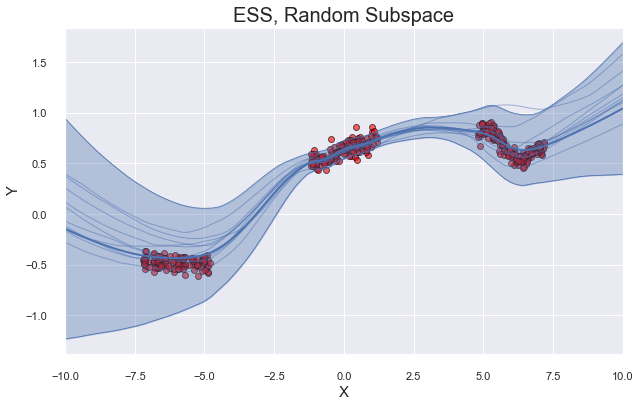

In [19]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
model = rs.model_info['model']  # pull model from subspace
ess = ESS(rs)  # initialize sampler with subspace
trajectories = []

for i in range(100):
    # Sample weights using ESS
    weights = ess.sample(1)[0]
    
    # Set model weights
    set_model_weights(model, weights)
    out = model(inp)
    
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)    
plot_predictive(data, trajectories, z, title="ESS, Random Subspace")

## Inference w/ ESS & PCA subspace

In [20]:
# Generate PCA subspace
class PCASubspace():
    def __init__(self, model_info, rank=10, preloaded=None):
        
        self.model_info = model_info
        self.rank = rank
        if preloaded is not None:
            print('Loading pretrained PCA weights...')
            self.shift = preloaded['swag_shift']
            self.A = preloaded['swag_A'].numpy()
            set_model_weights(self.model_info['model'], model_weights)
            
        else:
            print('Computing PCA Subspace...')
            self.shift, self.A = SWAG(model_info['model'], model_info['dataloader'], 
                             model_info['optimizer'], model_info['criterion'])
        
        # perform PCA on A matrix
        #  Note: in the code they fit A/sqrt(k - 1)
        _, s, Vt = randomized_svd(self.A/np.sqrt(self.rank-1), n_components=self.rank, n_iter=5)
        self.P = torch.FloatTensor(s[:, None] * Vt)

In [21]:
# Initialize PCA subspace
preloaded = preload()
model = MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=.95)
model_info = {'model': model, 'dataloader': dataloader, 'optimizer': optimizer, 'criterion': criterion}
pca_subspace = PCASubspace(model_info, preloaded=preloaded)

Loading pretrained PCA weights...


NameError: name 'model_weights' is not defined

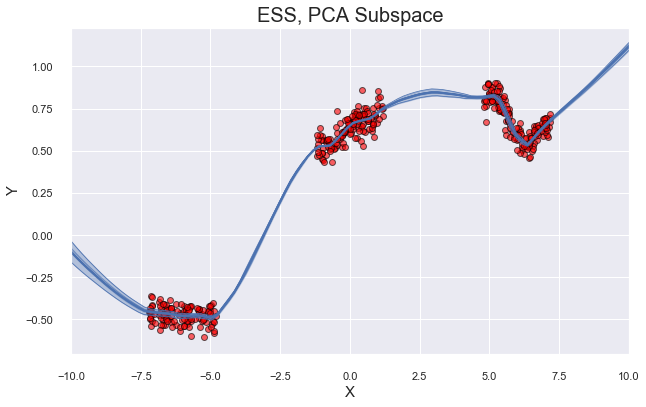

In [146]:
# Perform ESS sampling
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
model = pca_subspace.model_info['model']  # pull model from subspace
ess_pca = ESS(pca_subspace)  # initialize sampler with subspace
noise_var = .05  # .05
T = .15  # .15
pca_trajectories = []

for i in range(100):
    # Sample weights using ESS
    weights = ess_pca.sample(1, noise_var=noise_var, T=T)[0]
    
    # Set model weights
    set_model_weights(model, weights)
    out = model(inp)
    
    pca_trajectories.append(out.detach().numpy().ravel())

pca_trajectories = np.vstack(pca_trajectories)    
plot_predictive(data, pca_trajectories, z, title="ESS, PCA Subspace")